In [8]:
# !pip install numpy pandas tensorflow opencv-python pillow matplotlib seaborn scikit-learn

In [18]:
!ipynb-py-convert doan_3.ipynb plot.py

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
import os
import random
import time
import pickle

2025-08-03 21:27:16.576747: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-03 21:27:16.741012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754270836.879008    3802 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754270836.902850    3802 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754270837.029418    3802 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [13]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

In [14]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# random seeds 
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)

# Noi luu tru model sau khi huan luyen
os.makedirs('models', exist_ok=True)

# Configuration
IMAGE_SIZE = 256
BATCH_SIZE = 8
NUM_CLASSES = 5
RANDOM_STATE = 42

In [5]:
# ================== IMAGE PREPROCESSING FUNCTIONS ==================
# tang tuong phan cuc bo
def apply_CLAHE(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

# chinh sang toi
def adjust_gamma(img, gamma=1.5):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)
# tang tuong phan toan cuc
def global_hist_equal(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
# lam min vien
def smooth_bilateral(img):
    return cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

def addWeighted(img,sigmaX=10):
    return cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    
def enhance_fundus(img):
    img = apply_CLAHE(img)
    img = adjust_gamma(img, gamma=1.2)
    # img = cv2.GaussianBlur(img, (3, 3), 0)
    return img
def enhance_fundus2(img):
    img = apply_CLAHE(img)
    img = adjust_gamma(img, gamma=2)
    
    img = global_hist_equal(img)
    img = smooth_bilateral(img)
    return img

def crop_black(img, tol=7):
# ham xoa khoang den
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        
        if check_shape == 0:
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
            return img

def circle_crop(img, sigmaX=10):
# cat theo hinh tron
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))
    
    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    
    img = cv2.bitwise_and(img, img, mask=circle_img)
    return img

def random_crop(img, size=(0.9, 1)):
    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)
    
    img = img[i:h, j:w, :]
    
    return img

def prepare_image(path, sigmaX=10, do_random_crop=False):
    
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # cat den
    image = crop_black(image, tol=7)
    if do_random_crop:
        image = random_crop(image, size=(0.9, 1))
    
    # Resize and color enhancement
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  
    image = enhance_fundus(image)
    
    #cat tron
    image = circle_crop(image, sigmaX=sigmaX)
    
    # Normalize to [0, 1]
    image = image.astype(np.float32) / 255.0
    
    return image


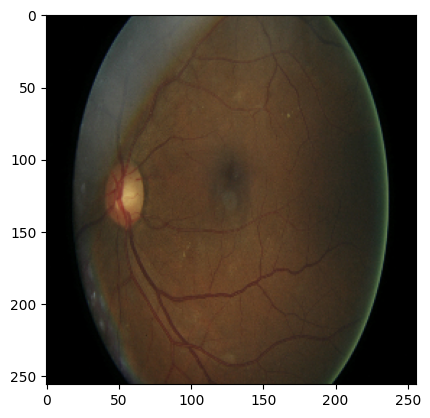

In [17]:
image_c=cv2.cvtColor(cv2.imread("train/1002_right.jpeg"), cv2.COLOR_BGR2RGB)
image_c = cv2.resize(image_c, (IMAGE_SIZE, IMAGE_SIZE))  
plt.imshow(image_c)


In [18]:
prepare_image("train/1002_right.jpeg").shape

(256, 256, 3)

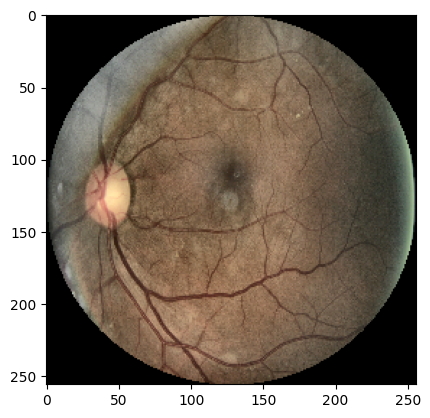

In [19]:
plt.imshow(prepare_image("train/1002_right.jpeg"))


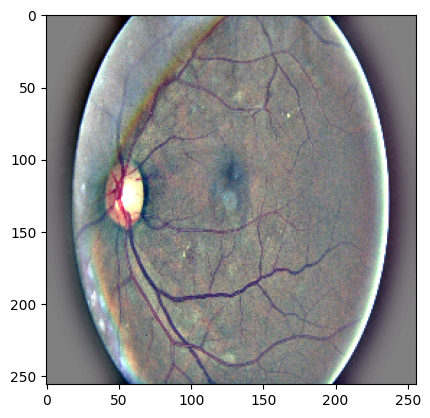

In [20]:
plt.imshow(addWeighted(image_c))

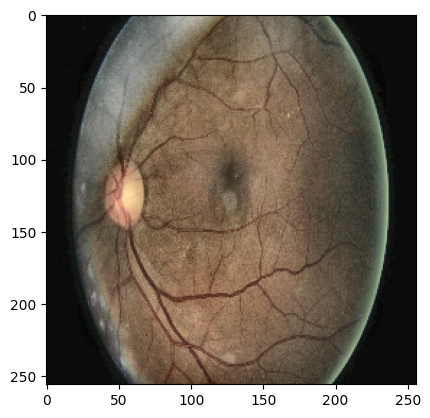

In [21]:
plt.imshow(enhance_fundus(image_c))

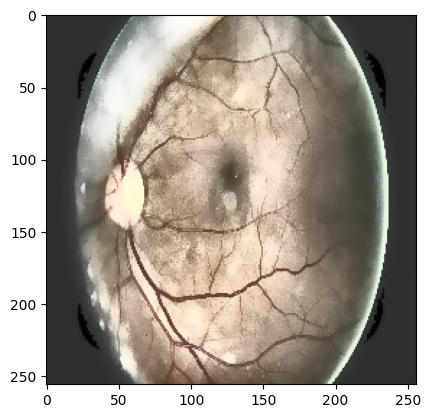

In [22]:
plt.imshow(enhance_fundus2(image_c))

In [6]:
# ================== CUSTOM DATA GENERATOR ==================

class DiabeticsDataGenerator(keras.utils.Sequence):
    def __init__(self, data, directory, batch_size=32, image_size=256, 
                 shuffle=True, augment=False, itype='.png'):
        self.data = data.reset_index(drop=True)
        self.directory = directory
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.itype = itype
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.data.iloc[batch_indexes]
        
        X, y = self.__data_generation(batch_data)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_data):
        X = np.empty((self.batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size,), dtype=int)
        
        for i, (idx, row) in enumerate(batch_data.iterrows()):
            img_path = os.path.join(self.directory, row['id_code'] + self.itype)
            
            # Load and preprocess image
            image = prepare_image(img_path, do_random_crop=self.augment)
            
            # Data augmentation
            if self.augment:
                # Random rotation
                if random.random() > 0.5:
                    angle = random.uniform(-180, 180)
                    image = tf.keras.preprocessing.image.apply_affine_transform(
                        image, theta=angle, row_axis=0, col_axis=1, channel_axis=2
                    )
                
                # Random flip
                if random.random() > 0.5:
                    image = np.fliplr(image)
                if random.random() > 0.5:
                    image = np.flipud(image)
            
            X[i] = image
            y[i] = row['diagnosis']
        
        return X, keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

In [7]:
# ================== MODEL ARCHITECTURE ==================



def create_pretrained_model():
    # model huan luyen dau
    
    base_model = EfficientNetB4(
        weights=None,
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        pooling='avg'
    )
    base_model.load_weights("models/efficientnetb4_notop.h5")

    for layer in base_model.layers[:-20]:  
        layer.trainable = False

    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = base_model(inputs, training=False)  
    

    x = layers.Dropout(0.3)(x)  
    x = layers.Dense(128, activation='relu')(x)  
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
 
    
    return model

def create_efficientnet_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=NUM_CLASSES, 
                             trainable_layers=50,weights_path=None):
    
    
    # EfficientNet B4
    base_model = EfficientNetB4(
        weights=None,
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )
    
    # Freeze base model layers ngoai tru may layer cuoi
    base_model.trainable = True
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    
   
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.3)(x)  
    x = layers.Dense(128, activation='relu')(x)  
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)

    # Load pre-trained weights
    if weights_path and os.path.exists(weights_path):
        model.load_weights(weights_path)
        print(f"Loaded weights {weights_path}")
    
    return model

In [8]:
# ================== CLASS WEIGHTS CALCULATION ==================
def calculate_class_weights(train_df):
    # Lấy unique classes va tinh weights
    classes = np.unique(train_df['diagnosis'])
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=train_df['diagnosis']
    )
    
    # Convert to dictionary
    class_weight_dict = dict(zip(classes, class_weights))
    
    print("Class distribution:")
    for cls in classes:
        count = len(train_df[train_df['diagnosis'] == cls])
        print(f"Class {cls}: {count} samples (weight: {class_weight_dict[cls]:.3f})")
    
    return class_weight_dict

def plot_class_distribution(train_df, title="Class Distribution"):
    plt.figure(figsize=(10, 6))
    class_counts = train_df['diagnosis'].value_counts().sort_index()
    
    plt.subplot(1, 2, 1)
    plt.bar(class_counts.index, class_counts.values)
    plt.title(f'{title} - Count')
    plt.xlabel('Diagnosis Level')
    plt.ylabel('Number of Samples')
    
    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values, labels=[f'Level {i}' for i in class_counts.index], 
            autopct='%1.1f%%', startangle=90)
    plt.title(f'{title} - Percentage')
    
    plt.tight_layout()
    plt.show()
    
    return class_counts

In [10]:
# ================== TRAINING FUNCTIONS ==================


def train_model_2015_data(train_df, val_df, train_dir, val_dir, 
                         model_name='efficientnet_b4_2015.weights'):
    # huan luyen truoc voi du lieu 2015 , khoang 35 nghin anh
    print("=" * 50)
    print("Train 2015 Data")
    
   
    train_gen = DiabeticsDataGenerator(
        data=train_df,
        directory=train_dir,
        batch_size=BATCH_SIZE,
        shuffle=True,
        augment=True,
        itype='.jpeg'
    )
    
    val_gen = DiabeticsDataGenerator(
        data=val_df,
        directory=val_dir,
        batch_size=BATCH_SIZE,
        shuffle=False,
        augment=False,
        itype='.png'
    )
    
   
    model = create_pretrained_model()
    

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-4
        ),
        callbacks.ModelCheckpoint(
            f'models/{model_name}.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True
        )
    ]
    
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        callbacks=callbacks_list,
        verbose=1
    )
    
    return model, history

def train_model_2019_data(train_df, train_dir, model_name, pretrained_weights, 
                         validation_split=0.2):
    # Train model 2019 dung StratifiedKFold
    
    print("=" * 50)
    print("Training 2019 Data")

     
   
    
   
    class_weights = calculate_class_weights(train_df)
    
    
    train_data, val_data = train_test_split(
        train_df, 
        test_size=validation_split, 
        stratify=train_df['diagnosis'],
        random_state=RANDOM_STATE
    )
    
    train_data = train_data.reset_index(drop=True)
    val_data = val_data.reset_index(drop=True)
        
       
    train_gen = DiabeticsDataGenerator(
            data=train_data,
            directory=train_dir,
            batch_size=BATCH_SIZE,
            shuffle=True,
            augment=True,
            itype='.png'
        )
        
    val_gen = DiabeticsDataGenerator(
            data=val_data,
            directory=train_dir,
            batch_size=BATCH_SIZE,
            shuffle=False,
            augment=False,
            itype='.png'
        )
        
     
    model = create_efficientnet_model(weights_path=pretrained_weights)
        
        
    # Compile model with only trainable layers
    model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        
    callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-7
            ),
            callbacks.ModelCheckpoint(
                f'models/{model_name}.h5',
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=False
            )
        ]
        
        
    history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=15,
            callbacks=callbacks_list,
            # class_weight=class_weights, 
            verbose=1
        )   
    
    return model,history


In [11]:
 #  2015 data pre-training
train_2015 = pd.read_csv('trainLabels/trainLabels.csv')
train_2015.columns = ['id_code', 'diagnosis']
test_2019 = pd.read_csv('aptos2019-blindness-detection/train.csv')
test_2019

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [33]:
train_2015

,id_code,diagnosis
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


In [ ]:
 # Pre-training  2015 data
model_2015, history_2015 = train_model_2015_data(
        train_df=train_2015,
        val_df=test_2019,
        train_dir='train',
        val_dir='aptos2019-blindness-detection/train_images'
    )

Train 2015 Data
Epoch 1/15
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.7294 - loss: 0.9182

2025-07-31 12:57:13.813968: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3996', 8 bytes spill stores, 8 bytes spill loads

2025-07-31 12:57:13.938892: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3996', 112 bytes spill stores, 112 bytes spill loads

2025-07-31 12:57:13.949508: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3996', 12 bytes spill stores, 12 bytes spill loads

2025-07-31 12:57:14.268431: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3996', 8 bytes spill stores, 8 bytes spill loads

2025-07-31 12:57:14.725664: I external/loc

4390/4390 ━━━━━━━━━━━━━━━━━━━━ 4721s 1s/step - accuracy: 0.7343 - loss: 0.8950 - val_accuracy: 0.4932 - val_loss: 1.4730 - learning_rate: 0.0010
Epoch 2/15
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 4551s 1s/step - accuracy: 0.7348 - loss: 0.8820 - val_accuracy: 0.4932 - val_loss: 1.4528 - learning_rate: 0.0010
Epoch 3/15
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 4661s 1s/step - accuracy: 0.7348 - loss: 0.8788 - val_accuracy: 0.4932 - val_loss: 1.4026 - learning_rate: 0.0010
Epoch 4/15
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 4598s 1s/step - accuracy: 0.7348 - loss: 0.8762 - val_accuracy: 0.4932 - val_loss: 1.4331 - learning_rate: 0.0010
Epoch 5/15
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 4648s 1s/step - accuracy: 0.7348 - loss: 0.8749 - val_accuracy: 0.4932 - val_loss: 1.4473 - learning_rate: 0.0010
Epoch 6/15
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 4695s 1s/step - accuracy: 0.7348 - loss: 0.8728 - val_accuracy: 0.4932 - val_loss: 1.4730 - learning_rate: 0.0010
Epoch 7/15
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 4634s 1s/step - accuracy: 0.7348 

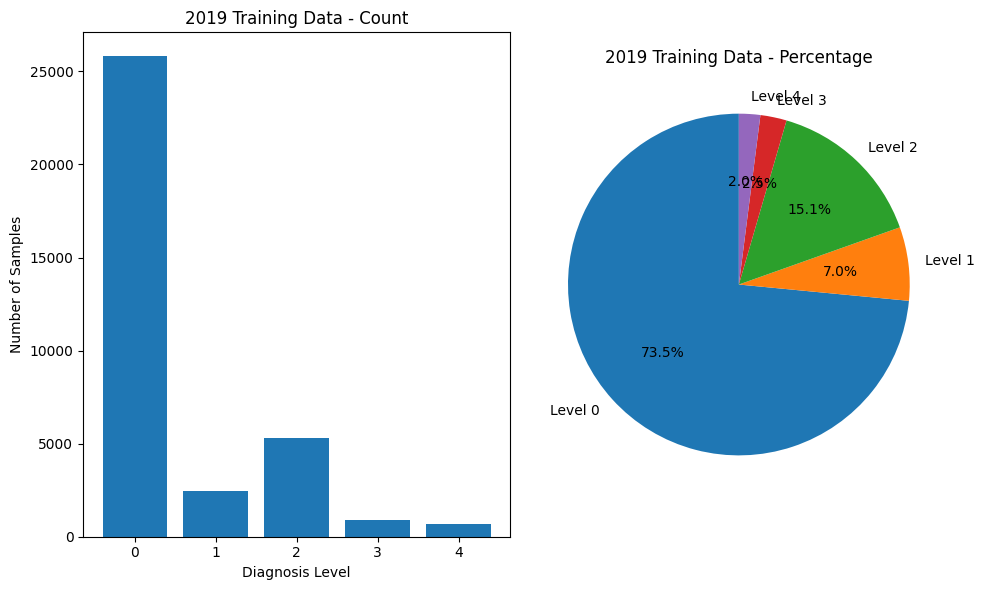

diagnosis
0    25810
1     2443
2     5292
3      873
4      708
Name: count, dtype: int64

In [12]:
plot_class_distribution(train_2015, "2019 Training Data")

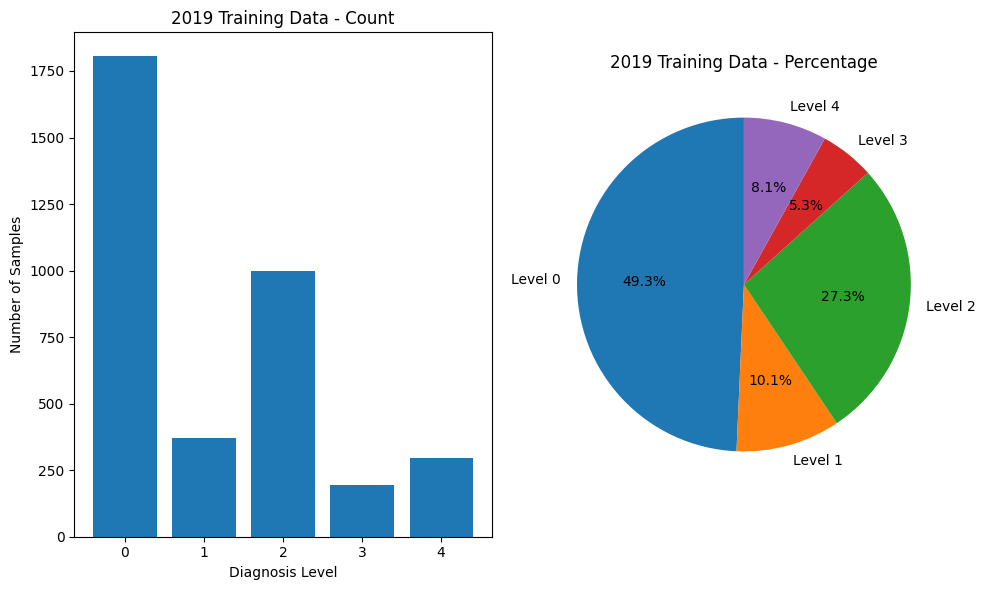

Training 2019 Data
Class distribution:
Class 0: 1805 samples (weight: 0.406)
Class 1: 370 samples (weight: 1.979)
Class 2: 999 samples (weight: 0.733)
Class 3: 193 samples (weight: 3.795)
Class 4: 295 samples (weight: 2.483)
Loaded weights models/efficientnet_b4_2015.weights.h5
Epoch 1/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.4917 - loss: 1.3558

366/366 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.4898 - loss: 1.3197 - val_accuracy: 0.4918 - val_loss: 1.2983 - learning_rate: 0.0010
Epoch 2/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.4932 - loss: 1.3062 - val_accuracy: 0.4918 - val_loss: 1.3043 - learning_rate: 0.0010
Epoch 3/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.4928 - loss: 1.3015 - val_accuracy: 0.4918 - val_loss: 1.2991 - learning_rate: 0.0010
Epoch 4/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.4679 - loss: 1.2783

366/366 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.4870 - loss: 1.2980 - val_accuracy: 0.4918 - val_loss: 1.2979 - learning_rate: 0.0010
Epoch 5/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.5091 - loss: 1.2826

366/366 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.4928 - loss: 1.3003 - val_accuracy: 0.4918 - val_loss: 1.2966 - learning_rate: 0.0010
Epoch 6/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.4928 - loss: 1.2986 - val_accuracy: 0.4918 - val_loss: 1.2988 - learning_rate: 0.0010
Epoch 7/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.4932 - loss: 1.2996 - val_accuracy: 0.4918 - val_loss: 1.2969 - learning_rate: 0.0010
Epoch 8/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.4932 - loss: 1.3005 - val_accuracy: 0.4918 - val_loss: 1.3008 - learning_rate: 0.0010
Epoch 9/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.5024 - loss: 1.2806

366/366 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.4932 - loss: 1.2997 - val_accuracy: 0.4918 - val_loss: 1.2965 - learning_rate: 5.0000e-04
Epoch 10/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.4932 - loss: 1.2964 - val_accuracy: 0.4918 - val_loss: 1.3034 - learning_rate: 5.0000e-04
Epoch 11/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.4932 - loss: 1.2975 - val_accuracy: 0.4918 - val_loss: 1.2985 - learning_rate: 5.0000e-04
Epoch 12/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.5083 - loss: 1.2850

366/366 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.4928 - loss: 1.2965 - val_accuracy: 0.4918 - val_loss: 1.2964 - learning_rate: 5.0000e-04
Epoch 13/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.4844 - loss: 1.3063

366/366 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.4932 - loss: 1.2962 - val_accuracy: 0.4918 - val_loss: 1.2961 - learning_rate: 2.5000e-04
Epoch 14/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.4932 - loss: 1.2958 - val_accuracy: 0.4918 - val_loss: 1.2966 - learning_rate: 2.5000e-04
Epoch 15/15
366/366 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.4932 - loss: 1.2945 - val_accuracy: 0.4918 - val_loss: 1.2965 - learning_rate: 2.5000e-04


In [33]:
   #  2019
train_2019 = pd.read_csv('aptos2019-blindness-detection/train.csv')
 # Plot 
plot_class_distribution(train_2019, "2019 Training Data")


model_2019, history_2019 = train_model_2019_data(
    train_df=train_2019,
    train_dir="aptos2019-blindness-detection/train_images",
    model_name='efficientnet_b4_2019',
    pretrained_weights='models/efficientnet_b4_2015.weights.h5',
    validation_split=0.2,
)

    

In [34]:
# luu
with open("models/history_2019.pkl", "wb") as f:
    pickle.dump(history_2019.history, f)


In [19]:
# ================== EVALUATION ==================

def plot_training_history(history):
  
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss', color='red')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', color='green')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].set_title('Training and Validation Loss')
    
    # Plot accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].set_title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, normalize=True):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', 
                cmap='Blues', square=True)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def evaluate_predictions(y_true, y_pred):
    # Chuyen predictions thanh class labels
    if y_pred.ndim > 1:
        y_pred_classes = np.argmax(y_pred, axis=1)
    else:
        y_pred_classes = y_pred
    
    # Calculate metrics
    kappa = cohen_kappa_score(y_true, y_pred_classes, weights='quadratic')
    accuracy = np.mean(y_true == y_pred_classes)
    
    print(f"Quadratic Weighted Kappa: {kappa:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes))
    
    # Confusion matrix
    plot_confusion_matrix(y_true, y_pred_classes)
    
    return kappa, accuracy

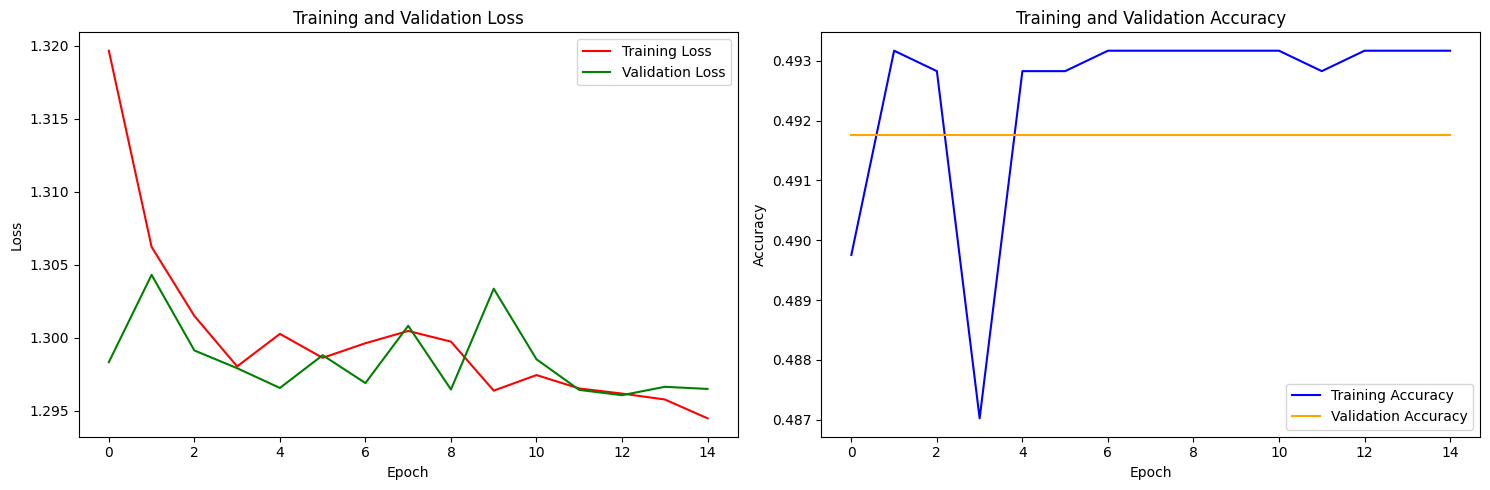

In [35]:
# load
with open("models/history_2019.pkl", "rb") as f:
    history_dict = pickle.load(f)

# Sau đó có thể plot:
plot_training_history(type('history', (object,), {"history": history_dict})())

In [20]:
plot_training_history(history_2019)

NameError: name 'history_2019' is not defined

In [ ]:
# Evaluate 
evaluate_predictions(train_2019['diagnosis'], oof_preds)